In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=a86442480637796660035c4caf6cdb41777e64db4915348c174f8ef1e8fc2e11
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import stddev, mean
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import array, array_repeat

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("DATA228Project").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing data and pre processing

In [ ]:
# Load CSV data as a DataFrame
df1 = spark.read.format("csv").option("header", "true").load("/content/drive/Shareddrives/Data 228/DATA/593824_37.34_-121.89_2019.csv")
df2 = spark.read.format("csv").option("header", "true").load("/content/drive/Shareddrives/Data 228/DATA/593824_37.34_-121.89_2020.csv")
df3 = spark.read.format("csv").option("header", "true").load("/content/drive/Shareddrives/Data 228/DATA/593824_37.34_-121.89_2021.csv")

In [ ]:
# Merge dataframes using union() method
df = df1.union(df2).union(df3)

In [ ]:
# Check for null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Null Value Counts:")
print(null_counts)

Null Value Counts:
   Year  Month  Day  Hour  Minute  DHI  Temperature  Clearsky DHI  \
0     0      0    0     0       0    0            0             0   

   Clearsky DNI  Clearsky GHI  ...  Fill Flag  GHI  Ozone  Relative Humidity  \
0             0             0  ...          0    0      0                  0   

   Solar Zenith Angle  Surface Albedo  Pressure  Precipitable Water  \
0                   0               0         0                   0   

   Wind Direction  Wind Speed  
0               0           0  

[1 rows x 23 columns]


In [ ]:
# Calculate number of rows and columns
num_rows = df.count()
num_cols = len(df.columns)

# Print the shape of the dataframe
print("Number of Rows: {}, Number of Columns: {}".format(num_rows, num_cols))

Number of Rows: 157824, Number of Columns: 23


In [ ]:
df.show(5)

+----+-----+---+----+------+---+------------------+------------+------------+------------+----------+-------------------+---+---------+---+-----+-----------------+------------------+--------------+--------+-------------------+--------------+----------+
|Year|Month|Day|Hour|Minute|DHI|       Temperature|Clearsky DHI|Clearsky DNI|Clearsky GHI|Cloud Type|          Dew Point|DNI|Fill Flag|GHI|Ozone|Relative Humidity|Solar Zenith Angle|Surface Albedo|Pressure| Precipitable Water|Wind Direction|Wind Speed|
+----+-----+---+----+------+---+------------------+------------+------------+------------+----------+-------------------+---+---------+---+-----+-----------------+------------------+--------------+--------+-------------------+--------------+----------+
|2019|    1|  1|   0|     0|  0|               2.1|           0|           0|           0|         0|-2.8000000000000000|  0|        0|  0|0.328|             70.2|            165.48|          0.13|    1022|0.30000000000000000|            29|

In [ ]:
columns_to_drop = ["Clearsky DHI", "Clearsky DNI","Clearsky GHI",'DNI','DHI','Dew Point','Surface Albedo']
df = df.drop(*columns_to_drop)

In [ ]:
df.show(5)

+----+-----+---+----+------+------------------+----------+---------+---+-----+-----------------+------------------+--------+-------------------+--------------+----------+
|Year|Month|Day|Hour|Minute|       Temperature|Cloud Type|Fill Flag|GHI|Ozone|Relative Humidity|Solar Zenith Angle|Pressure| Precipitable Water|Wind Direction|Wind Speed|
+----+-----+---+----+------+------------------+----------+---------+---+-----+-----------------+------------------+--------+-------------------+--------------+----------+
|2019|    1|  1|   0|     0|               2.1|         0|        0|  0|0.328|             70.2|            165.48|    1022|0.30000000000000000|            29|       1.6|
|2019|    1|  1|   0|    10|                 2|         0|        0|  0|0.327|             70.7|165.67000000000000|    1022|0.30000000000000000|            28|       1.6|
|2019|    1|  1|   0|    20|1.9000000000000000|         0|        0|  0|0.327|            71.28|            165.54|    1023|0.30000000000000000| 

In [ ]:
# Display the schema of the dataframe
df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Hour: string (nullable = true)
 |-- Minute: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Cloud Type: string (nullable = true)
 |-- Fill Flag: string (nullable = true)
 |-- GHI: string (nullable = true)
 |-- Ozone: string (nullable = true)
 |-- Relative Humidity: string (nullable = true)
 |-- Solar Zenith Angle: string (nullable = true)
 |-- Pressure: string (nullable = true)
 |-- Precipitable Water: string (nullable = true)
 |-- Wind Direction: string (nullable = true)
 |-- Wind Speed: string (nullable = true)



In [ ]:
# Loop through all columns of the dataframe
for column in df.columns:
    # Check if the column contains numeric values
    if df.select(column).dtypes[0][1] == 'string' and df.select(column).rdd.flatMap(lambda x: x).collect()[0].isdigit():
        # Convert string column to integer
        df = df.withColumn(column, col(column).cast(IntegerType()))
    elif df.select(column).dtypes[0][1] == 'string' and df.select(column).rdd.flatMap(lambda x: x).collect()[0].replace('.','',1).isdigit():
        # Convert string column to double
        df = df.withColumn(column, col(column).cast(DoubleType()))

df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Cloud Type: integer (nullable = true)
 |-- Fill Flag: integer (nullable = true)
 |-- GHI: integer (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Relative Humidity: double (nullable = true)
 |-- Solar Zenith Angle: double (nullable = true)
 |-- Pressure: integer (nullable = true)
 |-- Precipitable Water: double (nullable = true)
 |-- Wind Direction: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)



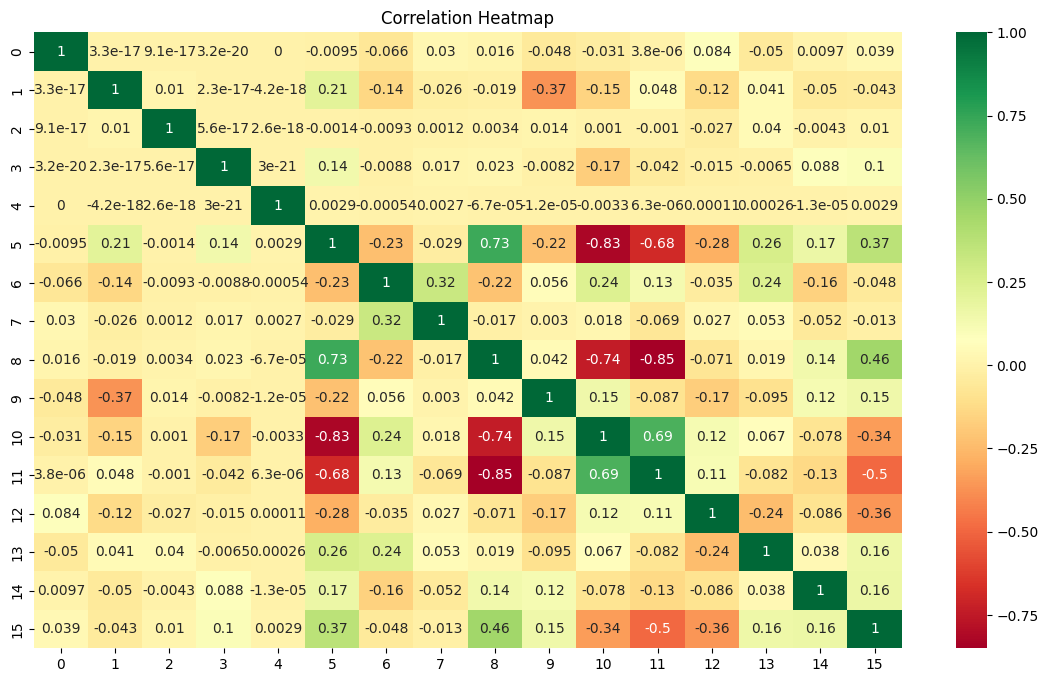

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Convert all columns to a vector using VectorAssembler
assembler = VectorAssembler(inputCols=df.columns, outputCol='features')
df_vector = assembler.transform(df).select('features')

# Compute the correlation matrix
matrix = Correlation.corr(df_vector, 'features').collect()[0][0]

# Convert the matrix to a list of lists
matrix_list = matrix.toArray().tolist()

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot the heatmap
sns.heatmap(matrix_list, annot=True, cmap='RdYlGn')

# Set the title of the heatmap
plt.title("Correlation Heatmap")

# Show the plot
plt.show()


In [ ]:
from pyspark.sql.functions import concat, col

# Combine year, month, day, and time columns into a single column
df_2 = df.withColumn("datetime", concat(col("Year"), col("Month"), col("Day")))

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_2.toPandas()


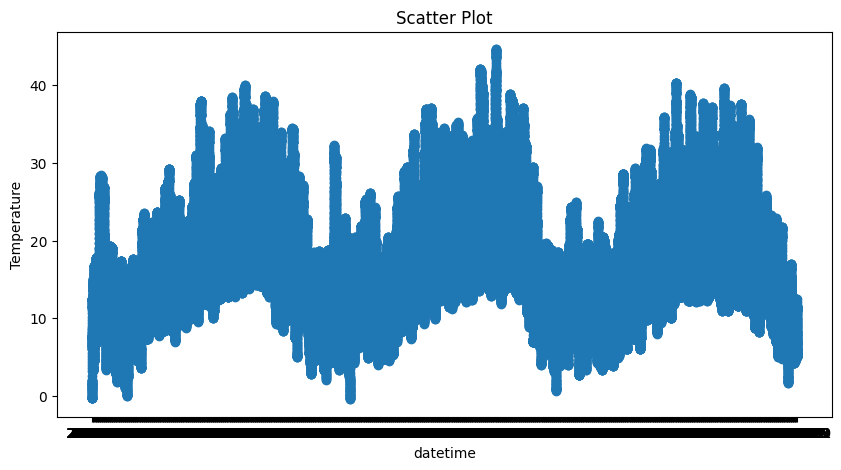

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Temperature'])
plt.xlabel('datetime')
plt.ylabel('Temperature')
plt.title('Scatter Plot')
plt.show()

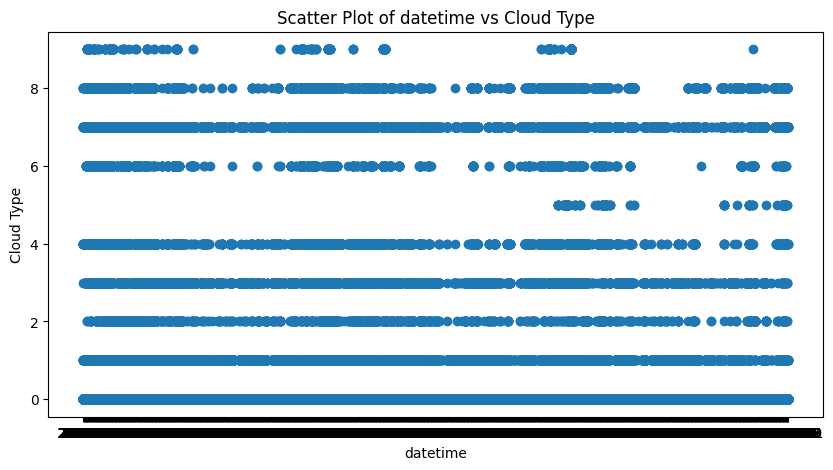

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Cloud Type'])
plt.xlabel('datetime')
plt.ylabel('Cloud Type')
plt.title('Scatter Plot of datetime vs Cloud Type')
plt.show()

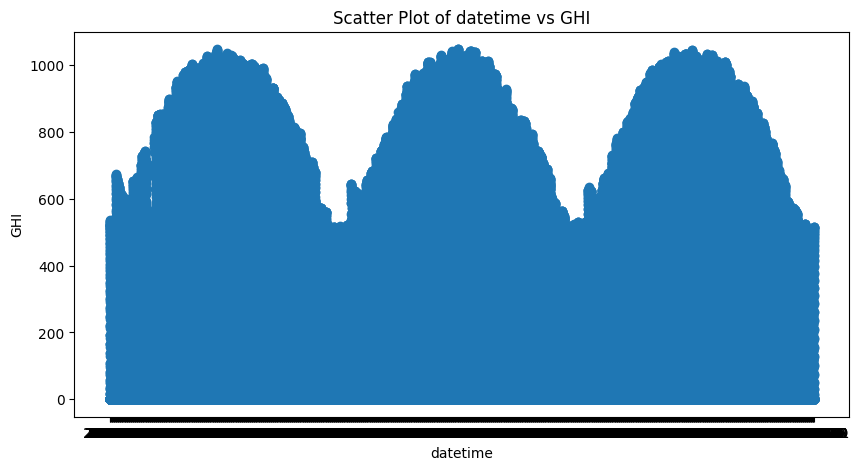

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['GHI'])
plt.xlabel('datetime')
plt.ylabel('GHI')
plt.title('Scatter Plot of datetime vs GHI')
plt.show()

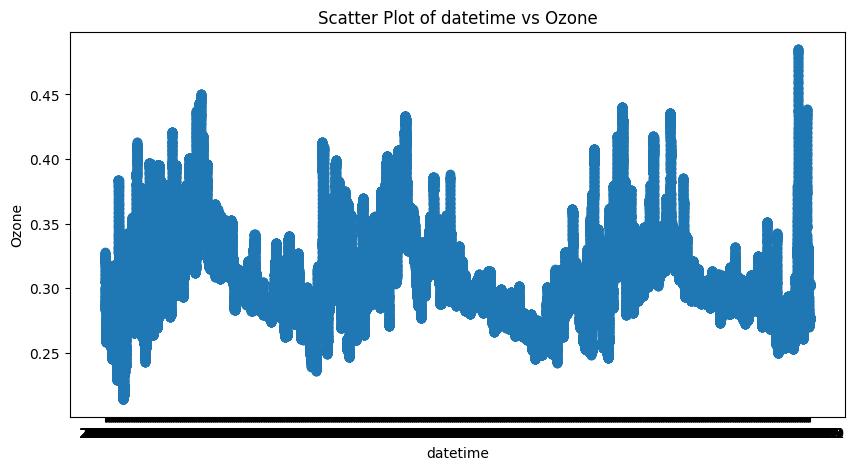

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Ozone'])
plt.xlabel('datetime')
plt.ylabel('Ozone')
plt.title('Scatter Plot of datetime vs Ozone')
plt.show()

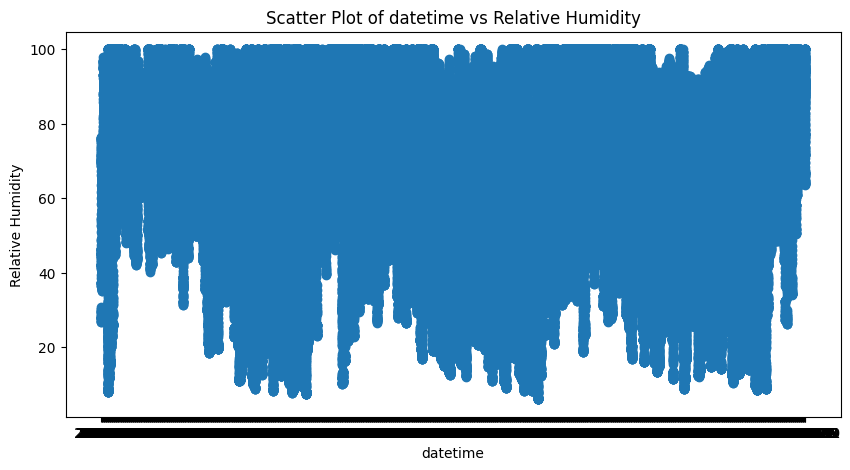

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Relative Humidity'])
plt.xlabel('datetime')
plt.ylabel('Relative Humidity')
plt.title('Scatter Plot of datetime vs Relative Humidity')
plt.show()

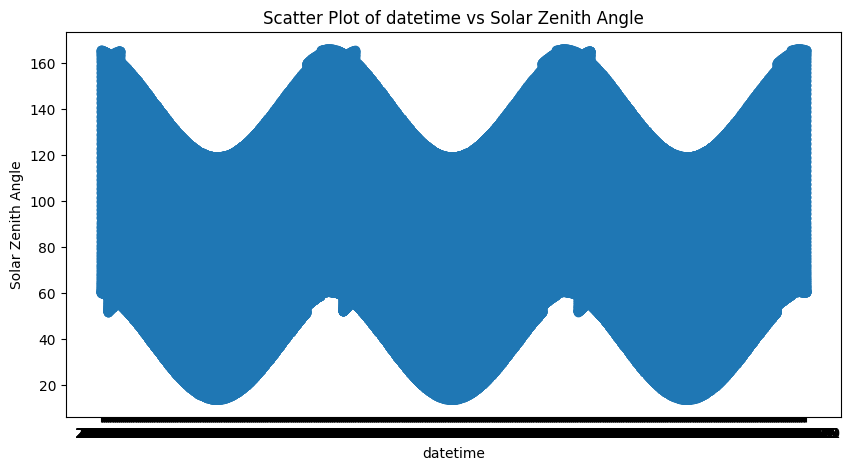

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Solar Zenith Angle'])
plt.xlabel('datetime')
plt.ylabel('Solar Zenith Angle')
plt.title('Scatter Plot of datetime vs Solar Zenith Angle')
plt.show()

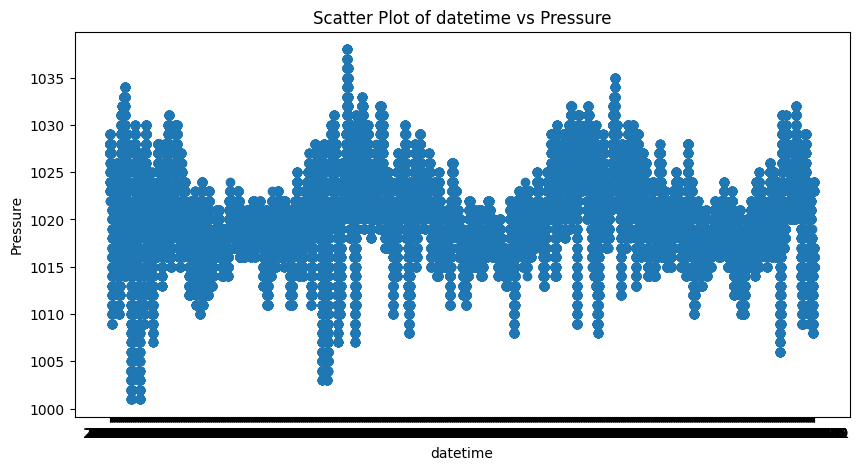

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Pressure'])
plt.xlabel('datetime')
plt.ylabel('Pressure')
plt.title('Scatter Plot of datetime vs Pressure')
plt.show()

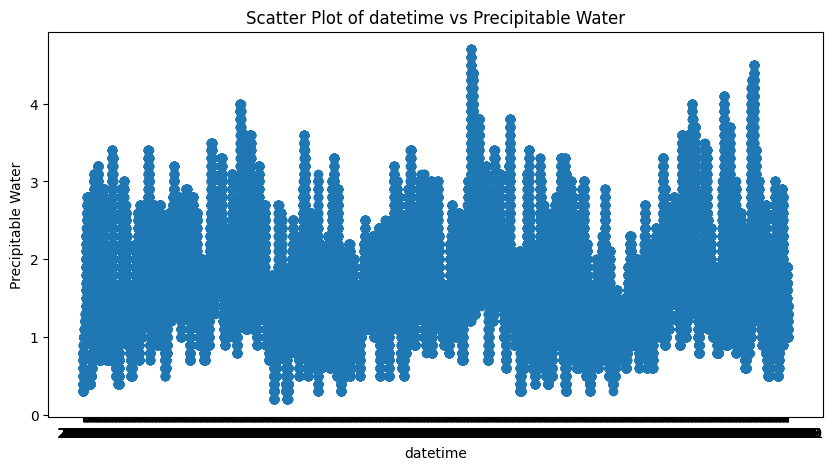

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Precipitable Water'])
plt.xlabel('datetime')
plt.ylabel('Precipitable Water')
plt.title('Scatter Plot of datetime vs Precipitable Water')
plt.show()

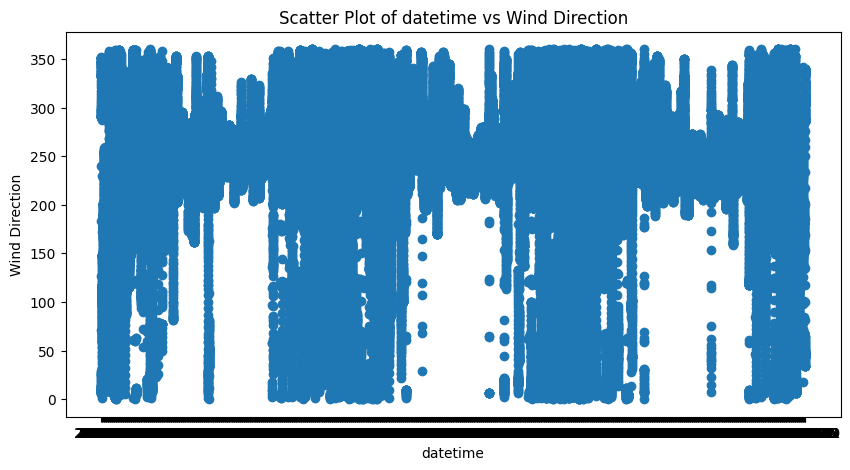

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Wind Direction'])
plt.xlabel('datetime')
plt.ylabel('Wind Direction')
plt.title('Scatter Plot of datetime vs Wind Direction')
plt.show()

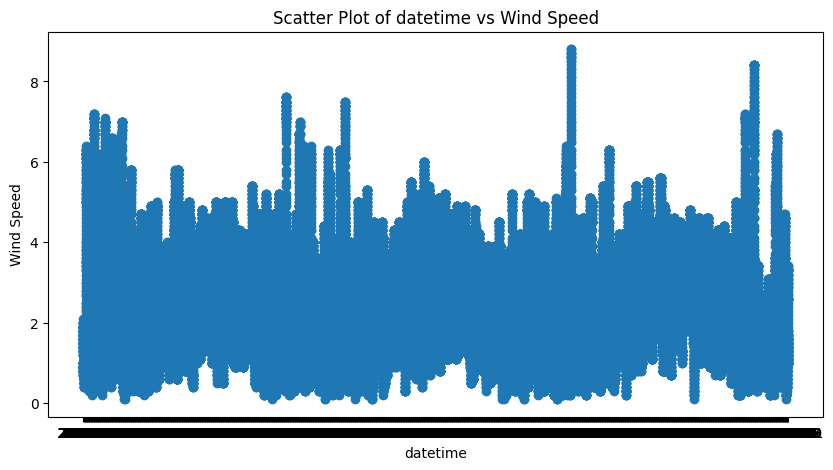

In [ ]:
# Plot scatter plot using matplotlib
# Set the figure size
plt.figure(figsize=(10,5))
plt.scatter(pandas_df['datetime'], pandas_df['Wind Speed'])
plt.xlabel('datetime')
plt.ylabel('Wind Speed')
plt.title('Scatter Plot of datetime vs Wind Speed')
plt.show()

In [ ]:
df.show(5)

+----+-----+---+----+------+-----------+----------+---------+---+-----+-----------------+------------------+--------+------------------+--------------+----------+
|Year|Month|Day|Hour|Minute|Temperature|Cloud Type|Fill Flag|GHI|Ozone|Relative Humidity|Solar Zenith Angle|Pressure|Precipitable Water|Wind Direction|Wind Speed|
+----+-----+---+----+------+-----------+----------+---------+---+-----+-----------------+------------------+--------+------------------+--------------+----------+
|2019|    1|  1|   0|     0|        2.1|         0|        0|  0|0.328|             70.2|            165.48|    1022|               0.3|            29|       1.6|
|2019|    1|  1|   0|    10|        2.0|         0|        0|  0|0.327|             70.7|            165.67|    1022|               0.3|            28|       1.6|
|2019|    1|  1|   0|    20|        1.9|         0|        0|  0|0.327|            71.28|            165.54|    1023|               0.3|            27|       1.6|
|2019|    1|  1|   0| 

# Train and test Split

In [ ]:

# Import required libraries
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.window import Window

# Split the data into training and test sets
# Calculate the split point
total_count = df.count()
split_point = int(total_count * 0.7)

# Add an index column
df1 = df.withColumn("index", monotonically_increasing_id())

# Create a window specification for ordering
window_spec = Window.orderBy("index")

# Split the data into training and testing sets based on the split point
trainingData = df1.filter(df1.index < split_point).orderBy("index")
testData = df1.filter(df1.index >= split_point).orderBy("index")


# Create a vector assembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=[col for col in df1.columns if col != "GHI"], outputCol="features")


In [ ]:
# Transform the training data using the vector assembler
trainingData = assembler.transform(trainingData).select("features", "GHI")


In [ ]:
trainingData.show(5,truncate=False)

+--------------------------------------------------------------------------------+---+
|features                                                                        |GHI|
+--------------------------------------------------------------------------------+---+
|[2019.0,1.0,1.0,0.0,0.0,2.1,0.0,0.0,0.328,70.2,165.48,1022.0,0.3,29.0,1.6,0.0]  |0  |
|[2019.0,1.0,1.0,0.0,10.0,2.0,0.0,0.0,0.327,70.7,165.67,1022.0,0.3,28.0,1.6,1.0] |0  |
|[2019.0,1.0,1.0,0.0,20.0,1.9,0.0,0.0,0.327,71.28,165.54,1023.0,0.3,27.0,1.6,2.0]|0  |
|[2019.0,1.0,1.0,0.0,30.0,1.9,0.0,0.0,0.327,71.28,165.1,1023.0,0.3,26.0,1.6,3.0] |0  |
|[2019.0,1.0,1.0,0.0,40.0,1.8,0.0,0.0,0.327,69.01,164.37,1023.0,0.3,25.0,1.6,4.0]|0  |
+--------------------------------------------------------------------------------+---+
only showing top 5 rows



# Random forest

In [ ]:
# define the random forest model
rf = RandomForestRegressor(labelCol = 'GHI', 
                featuresCol = 'features',
                 numTrees = 100,
                  maxDepth = 10)

In [ ]:
# random forest model fits on training Data
trained_rf = rf.fit(trainingData)

In [ ]:
# predciiton on test
y_pre = trained_rf.transform(testData)

In [ ]:
# function to evaluate model performance
# pre; the predicted result by test
# metric: the name of metric used
def evaluate(pre, metric):
  evaluator = RegressionEvaluator(labelCol="GHI", predictionCol="prediction", metricName=metric)
  r = evaluator.evaluate(pre)
  return r

In [ ]:
r2_rf = evaluate(y_pre, 'r2')
mae_rf = evaluate(y_pre, 'mae')
mse_rf = evaluate(y_pre, 'mse')
print(f'The determination of coeffient of random forest: {r2_rf}')
print(f'The mean absolute error of random forest: {mae_rf}')
print(f'The mean square error of random forest: {mse_rf}')

The determination of coeffient of random forest: 0.9829620433267875
The mean absolute error of random forest: 18.987721188608308
The mean square error of random forest: 1572.320261258445


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from pyspark.ml import Pipeline

In [ ]:
# Import required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Split data into features and target
X = pandas_df[['Year','Month','Day','Hour','Minute','Temperature','Cloud Type',
               'Fill Flag','Ozone','Relative Humidity','Solar Zenith Angle',
               'Pressure','Precipitable Water','Wind Direction','Wind Speed']]  
y = pandas_df['GHI']  # Replace with actual target column name

# Create Random Forest regression model
rf_model = RandomForestRegressor()

# Perform 5-fold cross-validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

scores

array([0.98174895, 0.98886558, 0.98613786, 0.98774462, 0.99194461])

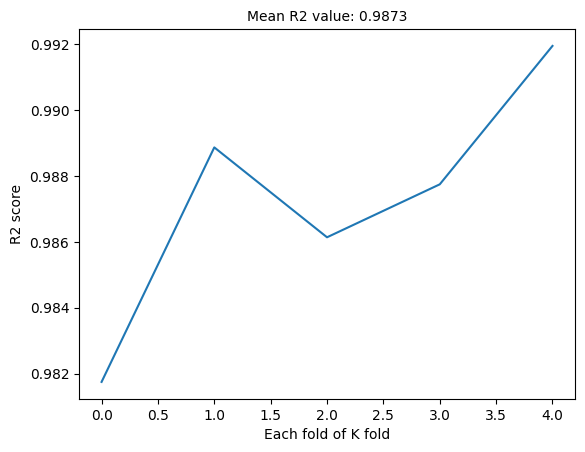

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)
x = np.arange(5)
y = scores
ax.set_ylabel('R2 score')
ax.set_xlabel('Each fold of K fold')
ax.set_title('Mean R2 value: {:.4f}'.format(scores.mean()), fontsize=10)
ax.plot(x,y)

## Model testing with newyork data

In [ ]:
newyork_data = spark.read.format("csv").option("header", "true").load("/content/drive/Shareddrives/Data 228/DATA/newyork_2021.csv")

In [ ]:
# Check for null values
null_counts = newyork_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Null Value Counts:")
print(null_counts)

Null Value Counts:
   Year  Month  Day  Hour  Minute  Temperature  Cloud Type  Fill Flag  GHI  \
0     0      0    0     0       0            0           0          0    0   

   Ozone  Relative Humidity  Solar Zenith Angle  Pressure  Precipitable Water  \
0      0                  0                   0         0                   0   

   Wind Direction  Wind Speed  
0               0           0  


In [ ]:
columns_to_drop = ["Clearsky DHI", "Clearsky DNI","Clearsky GHI",'DNI','DHI','Dew Point','Surface Albedo']
newyork_data = newyork_data.drop(*columns_to_drop)

In [ ]:
# Loop through all columns of the dataframe
for column in newyork_data.columns:
    # Check if the column contains numeric values
    if newyork_data.select(column).dtypes[0][1] == 'string' and newyork_data.select(column).rdd.flatMap(lambda x: x).collect()[0].isdigit():
        # Convert string column to integer
        newyork_data = newyork_data.withColumn(column, col(column).cast(IntegerType()))
    elif newyork_data.select(column).dtypes[0][1] == 'string' and newyork_data.select(column).rdd.flatMap(lambda x: x).collect()[0].replace('.','',1).isdigit():
        # Convert string column to double
        newyork_data = newyork_data.withColumn(column, col(column).cast(DoubleType()))

newyork_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Cloud Type: integer (nullable = true)
 |-- Fill Flag: integer (nullable = true)
 |-- GHI: integer (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Relative Humidity: double (nullable = true)
 |-- Solar Zenith Angle: double (nullable = true)
 |-- Pressure: integer (nullable = true)
 |-- Precipitable Water: double (nullable = true)
 |-- Wind Direction: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)



In [ ]:
newyork_data = newyork_data.withColumn("Temperature", col("Temperature").cast("double"))

In [ ]:
# Add an index column
newyork_data = newyork_data.withColumn("index", monotonically_increasing_id())
# Transform the test data using the vector assembler
ny_testData = assembler.transform(newyork_data).select("features", "GHI")

In [92]:
# predciiton on test
y_pre = trained_rf.transform(ny_testData)

In [93]:
r2_rf = evaluate(y_pre, 'r2')
mae_rf = evaluate(y_pre, 'mae')
mse_rf = evaluate(y_pre, 'mse')
print(f'The determination of coeffient of random forest: {r2_rf}')
print(f'The mean absolute error of random forest: {mae_rf}')
print(f'The mean square error of random forest: {mse_rf}')

The determination of coeffient of random forest: 0.9245153254238503
The mean absolute error of random forest: 33.75914600110262
The mean square error of random forest: 4741.401713475341


# Generalized linear regression


In [ ]:
from pyspark.ml.regression import GeneralizedLinearRegression

In [ ]:
# define the Generalized linear  regression model
ridge = GeneralizedLinearRegression(labelCol = 'GHI',
                    family = 'gaussian',
                    regParam = 0.5)

# train ridge model
trained_ridge = ridge.fit(trainingData)

# predict
Y_pred = trained_ridge.transform(testData)

In [ ]:
r2_glr = evaluate(Y_pred, 'r2')
mae_glr = evaluate(Y_pred, 'mae')
mse_glr = evaluate(Y_pred, 'mse')
print(f'The determination of coeffient of Generalized linear regression: {r2_glr}')
print(f'The mean absolute error of Generalized linear regression: {mae_glr}')
print(f'The mean square error of Generalized linear regression: {mse_glr}')

The determination of coeffient of Generalized linear regression: -29818794373.928864
The mean absolute error of Generalized linear regression: 48946512.575549744
The mean square error of Generalized linear regression: 2751779186979227.5


# Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

In [ ]:
# Extract the input features and target variable from the train and test sets
train_X = trainingData.select("features").rdd.map(lambda x: x[0]).collect()
train_y = trainingData.select("GHI").rdd.map(lambda x: x[0]).collect()
test_X = testData.select("features").rdd.map(lambda x: x[0]).collect()
test_y = testData.select("GHI").rdd.map(lambda x: x[0]).collect()

In [ ]:
# Apply PCA to reduce the dimensionality of the input features
n_components = 6  # Number of components for PCA
pca = PCA(n_components=n_components)
train_X_pca = pca.fit_transform(train_X)
test_X_pca = pca.transform(test_X)

# Train the SVR model
svr = SVR()
svr.fit(train_X_pca, train_y)

SVR()

In [ ]:
# Predict the target variable for the test set
pred_y = svr.predict(test_X_pca)

# Calculate MAE, RMSE, and R2 scores
mae = mean_absolute_error(test_y, pred_y)
rmse = mean_squared_error(test_y, pred_y, squared=False)
r2 = r2_score(test_y, pred_y)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)

MAE: 218.23730298511086
RMSE: 352.5020225468616
R2 Score: -0.34647943581002494


# Using only 5 features based on observations from correlation matrix

In [ ]:
selected_features = ["Month","Temperature", "Relative Humidity", "Solar Zenith Angle","Wind Speed","GHI"]
data_fs = df.select(selected_features)
data_fs.show(5)

+-----+-----------+-----------------+------------------+----------+---+
|Month|Temperature|Relative Humidity|Solar Zenith Angle|Wind Speed|GHI|
+-----+-----------+-----------------+------------------+----------+---+
|    1|        2.1|             70.2|            165.48|       1.6|  0|
|    1|        2.0|             70.7|            165.67|       1.6|  0|
|    1|        1.9|            71.28|            165.54|       1.6|  0|
|    1|        1.9|            71.28|             165.1|       1.6|  0|
|    1|        1.8|            69.01|            164.37|       1.6|  0|
|    1|        1.7|            69.51|            163.39|       1.6|  0|
|    1|        1.7|            69.51|            162.21|       1.6|  0|
|    1|        1.6|            70.01|            160.86|       1.7|  0|
|    1|        1.6|            70.01|            159.38|       1.7|  0|
|    1|        1.5|            70.51|            157.79|       1.7|  0|
|    1|        1.5|            68.73|            156.11|       1

In [ ]:
# Split the data into training and test sets
(trainingData_fs, testData_fs) = data_fs.randomSplit([0.7, 0.3])


# Create a vector assembler to combine features into a single vector column
assembler_fs = VectorAssembler(inputCols=[col for col in data_fs.columns if col != "GHI"], outputCol="features_fs")

In [ ]:
# Transform the training data using the vector assembler
trainingData_fs = assembler_fs.transform(trainingData_fs).select("features_fs", "GHI")

# Define the linear regression model
lr_fs = LinearRegression(featuresCol="features_fs", labelCol="GHI", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model to the training data
lrModel_fs = lr_fs.fit(trainingData_fs)

In [ ]:
# Transform the test data using the vector assembler
testData_fs = assembler_fs.transform(testData_fs).select("features_fs", "GHI")

# Make predictions on the test data
predictions = lrModel_fs.transform(testData_fs)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="GHI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [ ]:
trainingData_fs.show(5,truncate=False)

+--------------------+---+
|         features_fs|GHI|
+--------------------+---+
|[1.0,-0.3,76.27,1...|  0|
|[1.0,-0.3,76.35,1...|  0|
|[1.0,-0.2,75.72,1...|  0|
|[1.0,-0.2,75.8,10...|  0|
|[1.0,-0.2,75.8,10...|  0|
|[1.0,-0.2,76.08,9...|  0|
|[1.0,-0.2,76.08,9...|  0|
|[1.0,-0.2,76.08,9...|  0|
|[1.0,-0.1,75.62,1...|  0|
|[1.0,0.0,75.0,115...|  0|
|[1.0,0.0,75.07,11...|  0|
|[1.0,0.1,74.46,11...|  0|
|[1.0,0.4,72.92,92...|  0|
|[1.0,0.4,73.81,12...|  0|
|[1.0,0.5,73.27,12...|  0|
|[1.0,0.7,72.23,12...|  0|
|[1.0,0.8,71.64,13...|  0|
|[1.0,0.9,71.53,13...|  0|
|[1.0,0.9,71.53,13...|  0|
|[1.0,1.0,69.83,91...|  0|
+--------------------+---+
only showing top 20 rows



## GLR with 5 features

In [ ]:
# define the Generalized linear  regression model
ridge_fs = GeneralizedLinearRegression(labelCol = 'GHI',
                    featuresCol = "features_fs",
                    family = 'gaussian',
                    regParam = 0.5)

# train ridge model
trained_ridge_fs = ridge_fs.fit(trainingData_fs)

# predict
Y_pred = trained_ridge_fs.transform(testData_fs)

In [86]:
# predict
Y_pred = trained_ridge_fs.transform(testData_fs)
r2_glr = evaluate(Y_pred, 'r2')
mae_glr = evaluate(Y_pred, 'mae')
mse_glr = evaluate(Y_pred, 'mse')
print(f'The determination of coeffient of Generalized linear regression: {r2_glr}')
print(f'The mean absolute error of Generalized linear regression: {mae_glr}')
print(f'The mean square error of Generalized linear regression: {mse_glr}')

The determination of coeffient of Generalized linear regression: 0.7808288234285036
The mean absolute error of Generalized linear regression: 118.04724755787645
The mean square error of Generalized linear regression: 20928.499656105287


## SVR with 5 features

In [84]:
# Extract the input features and target variable from the train and test sets
train_X = trainingData_fs.select("features_fs").rdd.map(lambda x: x[0]).collect()
train_y = trainingData_fs.select("GHI").rdd.map(lambda x: x[0]).collect()
test_X = testData_fs.select("features_fs").rdd.map(lambda x: x[0]).collect()
test_y = testData_fs.select("GHI").rdd.map(lambda x: x[0]).collect()

In [82]:

# Apply PCA to reduce the dimensionality of the input features
n_components = 5  # Number of components for PCA
pca = PCA(n_components=n_components)
train_X_pca = pca.fit_transform(train_X)
test_X_pca = pca.transform(test_X)

# Train the SVR model
svr_fs = SVR()
svr_fs.fit(train_X_pca, train_y)

SVR()

In [85]:
# Predict the target variable for the test set
pred_y = svr_fs.predict(test_X_pca)

# Calculate MAE, RMSE, and R2 scores
mae = mean_absolute_error(test_y, pred_y)
rmse = mean_squared_error(test_y, pred_y, squared=False)
r2 = r2_score(test_y, pred_y)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)

MAE: 29.281515063004257
RMSE: 71.32106803301629
R2 Score: 0.9467302056754175


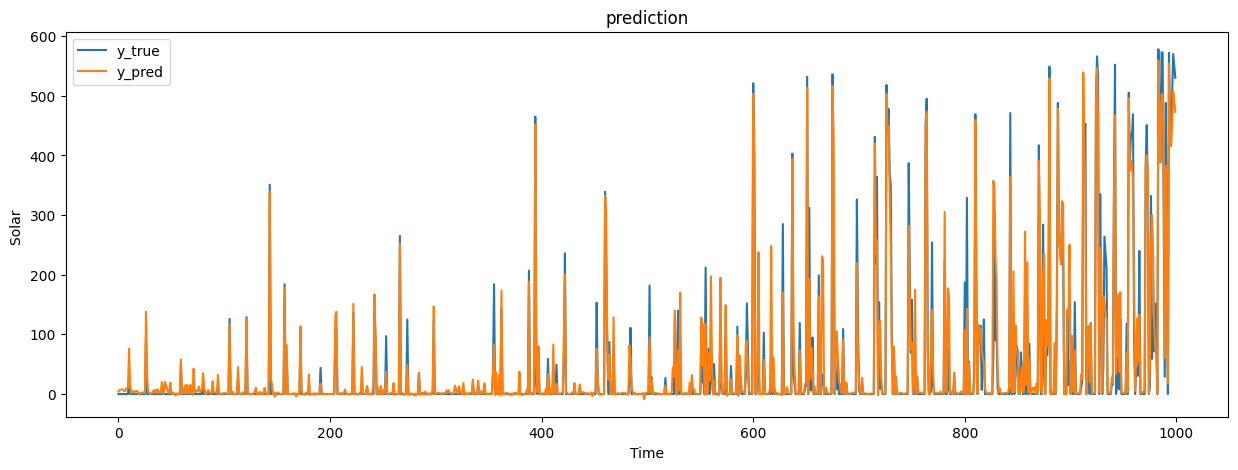

In [88]:
fig_acc = plt.figure(figsize=(15, 5))
plt.plot(test_y[:1000])
plt.plot(pred_y[:1000])
plt.title('prediction')
plt.ylabel('Solar ')
plt.xlabel('Time')
plt.legend(['y_true', 'y_pred'], loc='upper left')
plt.show()